Import Necessary Libraries

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import geopandas as gpd
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.ops import nearest_points

## Load Data from V2

In [57]:
cleaned_data = pd.read_csv('data_pre_norm.csv', index_col=0)
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal)
0,4.213002,-74.893581,313.9440,26.630280,14.712281,42863.912006,-43.6825,16042.943074,38240.015578,7608.200346,32274.809475,38166.067805,178510.268973,12107.518869,28.0,-54.87500,-107.350006,-155.604003
1,4.216078,-74.888898,313.3344,26.633328,21.294394,42855.311332,-43.6825,15471.824393,37942.352312,8075.823613,32849.251541,38767.181198,179076.006649,12521.081516,28.0,-54.87500,-107.350006,-155.604003
2,4.214720,-74.891220,316.3824,26.618088,23.783404,42859.265493,-43.6825,15751.330619,38097.704215,7838.753798,32567.674193,38474.927997,178798.267287,12309.048726,28.0,-54.87500,-107.350006,-155.604003
3,0.606276,-76.564731,275.2344,26.823828,24.156323,36310.810774,-3.9287,35178.987807,61605.456789,39427.671692,110966.615285,57996.892585,321929.890761,38740.878594,20.0,-0.40625,-26.175018,-58.520164
4,0.305911,-76.914853,90.5256,27.747372,25.601245,37832.879615,-2.2424,36371.533982,52965.253274,34306.255135,94735.671514,87776.161121,355936.702855,36506.159761,20.0,-3.53125,-27.399994,-55.094943


## Distance to basement (surface), V3

In [58]:
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm

# Convert 'cleaned_data' into a GeoDataFrame with WGS84 coordinates
gdf_cleaned_data = gpd.GeoDataFrame(
    cleaned_data,
    geometry=gpd.points_from_xy(cleaned_data.Longitude, cleaned_data.Latitude),
    crs="EPSG:4326"  # WGS84
)

# Load the 'basement' shapefile
basement = gpd.read_file('data/Geology/Rock_types.shx')

# Filter 'basement' to only include rows where 'classified' equals 1
basement_classified_1 = basement[basement['classified'] == 1]

# Reproject both GeoDataFrames to MAGNA-SIRGAS (EPSG:3116)
gdf_cleaned_data = gdf_cleaned_data.to_crs("EPSG:3116")
basement_classified_1 = basement_classified_1.to_crs("EPSG:3116")

# Initialize a column for the distances
cleaned_data['Nearest Basement'] = np.nan

# Calculate the distance from each point in 'gdf_cleaned_data' to the nearest '1' in 'basement_classified_1'
for index, row in tqdm(gdf_cleaned_data.iterrows(), total=gdf_cleaned_data.shape[0], desc="Calculating distances"):
    # Calculate the distance to the nearest point in 'basement_classified_1' and update the 'distance_to_1' column
    cleaned_data.at[index, 'Nearest Basement'] = basement_classified_1.distance(row.geometry).min()

Calculating distances: 100%|██████████| 4543/4543 [00:46<00:00, 96.95it/s] 


In [59]:
cleaned_data

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement
0,4.213002,-74.893581,313.9440,26.630280,14.712281,42863.912006,-43.6825,16042.943074,38240.015578,7608.200346,32274.809475,38166.067805,178510.268973,12107.518869,28.0,-54.87500,-107.350006,-155.604003,26430.359640
1,4.216078,-74.888898,313.3344,26.633328,21.294394,42855.311332,-43.6825,15471.824393,37942.352312,8075.823613,32849.251541,38767.181198,179076.006649,12521.081516,28.0,-54.87500,-107.350006,-155.604003,26807.505168
2,4.214720,-74.891220,316.3824,26.618088,23.783404,42859.265493,-43.6825,15751.330619,38097.704215,7838.753798,32567.674193,38474.927997,178798.267287,12309.048726,28.0,-54.87500,-107.350006,-155.604003,26613.393422
3,0.606276,-76.564731,275.2344,26.823828,24.156323,36310.810774,-3.9287,35178.987807,61605.456789,39427.671692,110966.615285,57996.892585,321929.890761,38740.878594,20.0,-0.40625,-26.175018,-58.520164,43126.506306
4,0.305911,-76.914853,90.5256,27.747372,25.601245,37832.879615,-2.2424,36371.533982,52965.253274,34306.255135,94735.671514,87776.161121,355936.702855,36506.159761,20.0,-3.53125,-27.399994,-55.094943,43893.018161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538,9.198753,-74.545831,14.9352,28.125324,22.902864,37255.351981,-29.3196,67951.218564,84851.479187,56595.020520,88505.305904,64495.836547,259372.804468,80852.179701,20.0,-0.53125,-40.925020,-39.287390,40390.065825
4539,9.193783,-74.545203,17.6784,28.111608,23.599190,37242.152495,-29.3196,67503.732300,84298.012717,56071.263149,87971.739857,64199.313789,258821.634484,80298.996774,20.0,-0.53125,-40.925020,-39.287390,39863.481446
4540,9.210378,-74.266786,21.3360,28.093320,22.529272,37076.390931,-59.0881,49589.080907,56467.948967,52443.767658,83005.223439,40008.137041,255540.784076,69911.233325,24.0,-12.87500,-40.475006,-37.082959,32815.518722
4541,8.213381,-72.470731,86.8680,27.765660,23.098588,36883.953489,21.7434,9812.610984,94782.592997,11630.076088,196307.990555,38178.497828,223384.739466,5879.044197,32.0,-40.43750,-87.850006,-103.230325,31514.418056


## Volcanic domain weights

In [60]:
from geopy.distance import great_circle

# Load the volcanic zone locations
volcanic_zones_df = pd.read_csv('data/Volcanes_col.csv')
# Convert to a GeoDataFrame
gdf_volcanic_zones = gpd.GeoDataFrame(
    volcanic_zones_df,
    geometry=gpd.points_from_xy(volcanic_zones_df.X, volcanic_zones_df.Y),
    crs='EPSG:4326'  # assuming the coordinates are in WGS84
)

gdf_volcanic_zones = gdf_volcanic_zones.to_crs('EPSG:3116')
gdf_cleaned_data = gdf_cleaned_data.to_crs('EPSG:3116')

# Redefine the calculate_distance_to_volcano function
def calculate_distance_to_volcano(row, volcanic_zones):
    distances = volcanic_zones.distance(row.geometry)
    return distances.min()

# Use tqdm to show a progress bar
tqdm.pandas(desc="Calculating distances to nearest volcano")
cleaned_data['Nearest Volcano'] = gdf_cleaned_data.progress_apply(
    lambda row: calculate_distance_to_volcano(row, gdf_volcanic_zones['geometry']),
    axis=1
)

# Define a threshold for proximity to volcanic zones
volcanic_proximity_threshold = 50000  # Example threshold

# Flag wells as near or not near a volcano
cleaned_data['Volcanic domain'] = cleaned_data['Nearest Volcano'] < volcanic_proximity_threshold

Calculating distances to nearest volcano:   0%|          | 0/4543 [00:00<?, ?it/s]

Calculating distances to nearest volcano: 100%|██████████| 4543/4543 [00:00<00:00, 6845.93it/s]


In [61]:
cleaned_data

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,...,Right-lateral Fault,Normal Fault,Active Fault,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement,Nearest Volcano,Volcanic domain
0,4.213002,-74.893581,313.9440,26.630280,14.712281,42863.912006,-43.6825,16042.943074,38240.015578,7608.200346,...,38166.067805,178510.268973,12107.518869,28.0,-54.87500,-107.350006,-155.604003,26430.359640,37574.493842,True
1,4.216078,-74.888898,313.3344,26.633328,21.294394,42855.311332,-43.6825,15471.824393,37942.352312,8075.823613,...,38767.181198,179076.006649,12521.081516,28.0,-54.87500,-107.350006,-155.604003,26807.505168,37828.184637,True
2,4.214720,-74.891220,316.3824,26.618088,23.783404,42859.265493,-43.6825,15751.330619,38097.704215,7838.753798,...,38474.927997,178798.267287,12309.048726,28.0,-54.87500,-107.350006,-155.604003,26613.393422,37691.342706,True
3,0.606276,-76.564731,275.2344,26.823828,24.156323,36310.810774,-3.9287,35178.987807,61605.456789,39427.671692,...,57996.892585,321929.890761,38740.878594,20.0,-0.40625,-26.175018,-58.520164,43126.506306,74754.728085,False
4,0.305911,-76.914853,90.5256,27.747372,25.601245,37832.879615,-2.2424,36371.533982,52965.253274,34306.255135,...,87776.161121,355936.702855,36506.159761,20.0,-3.53125,-27.399994,-55.094943,43893.018161,84568.777113,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538,9.198753,-74.545831,14.9352,28.125324,22.902864,37255.351981,-29.3196,67951.218564,84851.479187,56595.020520,...,64495.836547,259372.804468,80852.179701,20.0,-0.53125,-40.925020,-39.287390,40390.065825,395256.804800,False
4539,9.193783,-74.545203,17.6784,28.111608,23.599190,37242.152495,-29.3196,67503.732300,84298.012717,56071.263149,...,64199.313789,258821.634484,80298.996774,20.0,-0.53125,-40.925020,-39.287390,39863.481446,394718.812048,False
4540,9.210378,-74.266786,21.3360,28.093320,22.529272,37076.390931,-59.0881,49589.080907,56467.948967,52443.767658,...,40008.137041,255540.784076,69911.233325,24.0,-12.87500,-40.475006,-37.082959,32815.518722,401244.977788,False
4541,8.213381,-72.470731,86.8680,27.765660,23.098588,36883.953489,21.7434,9812.610984,94782.592997,11630.076088,...,38178.497828,223384.739466,5879.044197,32.0,-40.43750,-87.850006,-103.230325,31514.418056,395121.959675,False


### Assign sample weights based on proximity to a volcano

In [62]:
cleaned_data['Volcanic weight'] = cleaned_data['Volcanic domain'].apply(lambda x: 4 if not x else 1)

In [63]:
cleaned_data

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,...,Normal Fault,Active Fault,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement,Nearest Volcano,Volcanic domain,Volcanic weight
0,4.213002,-74.893581,313.9440,26.630280,14.712281,42863.912006,-43.6825,16042.943074,38240.015578,7608.200346,...,178510.268973,12107.518869,28.0,-54.87500,-107.350006,-155.604003,26430.359640,37574.493842,True,1
1,4.216078,-74.888898,313.3344,26.633328,21.294394,42855.311332,-43.6825,15471.824393,37942.352312,8075.823613,...,179076.006649,12521.081516,28.0,-54.87500,-107.350006,-155.604003,26807.505168,37828.184637,True,1
2,4.214720,-74.891220,316.3824,26.618088,23.783404,42859.265493,-43.6825,15751.330619,38097.704215,7838.753798,...,178798.267287,12309.048726,28.0,-54.87500,-107.350006,-155.604003,26613.393422,37691.342706,True,1
3,0.606276,-76.564731,275.2344,26.823828,24.156323,36310.810774,-3.9287,35178.987807,61605.456789,39427.671692,...,321929.890761,38740.878594,20.0,-0.40625,-26.175018,-58.520164,43126.506306,74754.728085,False,4
4,0.305911,-76.914853,90.5256,27.747372,25.601245,37832.879615,-2.2424,36371.533982,52965.253274,34306.255135,...,355936.702855,36506.159761,20.0,-3.53125,-27.399994,-55.094943,43893.018161,84568.777113,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538,9.198753,-74.545831,14.9352,28.125324,22.902864,37255.351981,-29.3196,67951.218564,84851.479187,56595.020520,...,259372.804468,80852.179701,20.0,-0.53125,-40.925020,-39.287390,40390.065825,395256.804800,False,4
4539,9.193783,-74.545203,17.6784,28.111608,23.599190,37242.152495,-29.3196,67503.732300,84298.012717,56071.263149,...,258821.634484,80298.996774,20.0,-0.53125,-40.925020,-39.287390,39863.481446,394718.812048,False,4
4540,9.210378,-74.266786,21.3360,28.093320,22.529272,37076.390931,-59.0881,49589.080907,56467.948967,52443.767658,...,255540.784076,69911.233325,24.0,-12.87500,-40.475006,-37.082959,32815.518722,401244.977788,False,4
4541,8.213381,-72.470731,86.8680,27.765660,23.098588,36883.953489,21.7434,9812.610984,94782.592997,11630.076088,...,223384.739466,5879.044197,32.0,-40.43750,-87.850006,-103.230325,31514.418056,395121.959675,False,4


## Handling under and over represented gradients data

In [64]:
high_gradient_threshold = cleaned_data['Apparent Geothermal Gradient (°C/Km)'].quantile(0.90)
print(f"High gradient threshold (90th percentile): {high_gradient_threshold}")

High gradient threshold (90th percentile): 31.496595948063767


In [65]:
extreme_gradient_threshold = cleaned_data['Apparent Geothermal Gradient (°C/Km)'].quantile(0.99)
print(f"High gradient threshold (99th percentile): {extreme_gradient_threshold}")

High gradient threshold (99th percentile): 43.80890461174968


In [66]:
lowest_gradient_threshold = cleaned_data['Apparent Geothermal Gradient (°C/Km)'].quantile(0.01)
print(f"High gradient threshold (01st percentile): {lowest_gradient_threshold}")

High gradient threshold (01st percentile): 14.87317986940993


In [67]:
lowest_gradient_threshold = cleaned_data['Apparent Geothermal Gradient (°C/Km)'].quantile(0.01)
print(f"High gradient threshold (01st percentile): {lowest_gradient_threshold}")

High gradient threshold (01st percentile): 14.87317986940993


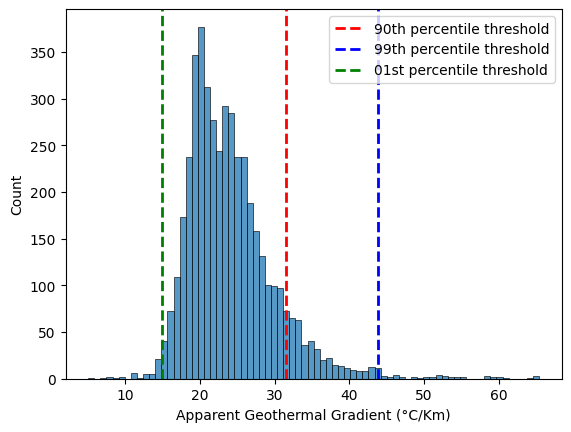

In [68]:
sns.histplot(cleaned_data['Apparent Geothermal Gradient (°C/Km)'], kde=False)
plt.axvline(high_gradient_threshold, color='red', linestyle='--', linewidth=2, label='90th percentile threshold')
plt.axvline(extreme_gradient_threshold, color='blue', linestyle='--', linewidth=2, label='99th percentile threshold')
plt.axvline(lowest_gradient_threshold, color='green', linestyle='--', linewidth=2, label='01st percentile threshold')
plt.legend()
plt.show()

In [69]:
# Calculate the number of samples below the high gradient threshold
num_low_gradients = (cleaned_data['Apparent Geothermal Gradient (°C/Km)'] <= high_gradient_threshold).sum()

# Calculate the number of samples above the high gradient threshold
num_high_gradients = (cleaned_data['Apparent Geothermal Gradient (°C/Km)'] > high_gradient_threshold).sum()

# Calculate the number of samples below the high gradient threshold
num_lowest_gradients = (cleaned_data['Apparent Geothermal Gradient (°C/Km)'] <= lowest_gradient_threshold).sum()

# Calculate the ratio of low to high and lowest gradient samples
low_to_high_ratio = num_low_gradients / num_high_gradients
low_to_lowest_ratio = num_low_gradients / num_lowest_gradients

print(f"Ratio of low to high gradient values: {low_to_high_ratio}")
print(f"Ratio of low to lowest gradient values: {low_to_lowest_ratio}")

Ratio of low to high gradient values: 8.984615384615385
Ratio of low to lowest gradient values: 88.8695652173913


In [70]:
high_gradient_weight_multiplier = 4  # This can be adjusted based on further model evaluation

Delete data above extreme and below lowest geothermal gradient thereshold

In [71]:
cleaned_data = cleaned_data[cleaned_data['Apparent Geothermal Gradient (°C/Km)'] <= extreme_gradient_threshold]
cleaned_data = cleaned_data[cleaned_data['Apparent Geothermal Gradient (°C/Km)'] >= lowest_gradient_threshold]

In [72]:
# Increase the weights for samples above the high gradient threshold
cleaned_data['High Gradient weight'] = np.where(
    cleaned_data['Apparent Geothermal Gradient (°C/Km)'] > high_gradient_threshold,
    high_gradient_weight_multiplier,
    1
)

## Multiply the volcanic weights by the high gradient weights to get the final sample weights

In [73]:
cleaned_data['sample_weight'] = cleaned_data['Volcanic weight'] * cleaned_data['High Gradient weight']

In [74]:
weights = cleaned_data['sample_weight']

## Save dataset with weights

In [75]:
cleaned_data.to_csv('data_weights.csv')

In [76]:
cleaned_data = pd.read_csv('data_weights.csv', index_col=0)
cleaned_data

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,...,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement,Nearest Volcano,Volcanic domain,Volcanic weight,High Gradient weight,sample_weight
1,4.216078,-74.888898,313.3344,26.633328,21.294394,42855.311332,-43.6825,15471.824393,37942.352312,8075.823613,...,28.0,-54.87500,-107.350006,-155.604003,26807.505168,37828.184637,True,1,1,1
2,4.214720,-74.891220,316.3824,26.618088,23.783404,42859.265493,-43.6825,15751.330619,38097.704215,7838.753798,...,28.0,-54.87500,-107.350006,-155.604003,26613.393422,37691.342706,True,1,1,1
3,0.606276,-76.564731,275.2344,26.823828,24.156323,36310.810774,-3.9287,35178.987807,61605.456789,39427.671692,...,20.0,-0.40625,-26.175018,-58.520164,43126.506306,74754.728085,False,4,1,4
4,0.305911,-76.914853,90.5256,27.747372,25.601245,37832.879615,-2.2424,36371.533982,52965.253274,34306.255135,...,20.0,-3.53125,-27.399994,-55.094943,43893.018161,84568.777113,False,4,1,4
5,0.287539,-76.911964,297.4848,26.712576,26.559722,37704.400313,-2.2424,37519.198283,54966.653565,35746.349888,...,20.0,-3.53125,-11.125000,-50.959084,45088.511661,86366.785176,False,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538,9.198753,-74.545831,14.9352,28.125324,22.902864,37255.351981,-29.3196,67951.218564,84851.479187,56595.020520,...,20.0,-0.53125,-40.925020,-39.287390,40390.065825,395256.804800,False,4,1,4
4539,9.193783,-74.545203,17.6784,28.111608,23.599190,37242.152495,-29.3196,67503.732300,84298.012717,56071.263149,...,20.0,-0.53125,-40.925020,-39.287390,39863.481446,394718.812048,False,4,1,4
4540,9.210378,-74.266786,21.3360,28.093320,22.529272,37076.390931,-59.0881,49589.080907,56467.948967,52443.767658,...,24.0,-12.87500,-40.475006,-37.082959,32815.518722,401244.977788,False,4,1,4
4541,8.213381,-72.470731,86.8680,27.765660,23.098588,36883.953489,21.7434,9812.610984,94782.592997,11630.076088,...,32.0,-40.43750,-87.850006,-103.230325,31514.418056,395121.959675,False,4,1,4


## Normalization of the data

Input data needs to be normalized as the features are in different scales. Target (heat flow) is not being normalized.

In [77]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Elevation (m)', 'Surface Temperature (°C)',
       'Moho Depth (m)', 'Curie Depth (Km)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Nearest Basement', 'Nearest Volcano',
       'Magnetic Anomaly (nT)', 'Vertical Gravity Gradient (E)', 
       'Free Air Anomaly (mGal)','Bouguer Anomaly (mGal)']

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
cleaned_data[columns_to_normalize] = scaler.fit_transform(cleaned_data[columns_to_normalize])

# Save the normalized data to a new CSV file
cleaned_data.to_csv('normalized_data_minmax.csv', index=False)

In [78]:
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,...,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement,Nearest Volcano,Volcanic domain,Volcanic weight,High Gradient weight,sample_weight
1,4.216078,-74.888898,0.100557,0.899443,21.294394,0.720455,0.359897,0.053527,0.102362,0.022877,...,0.642857,0.341539,0.096100,0.241172,0.107926,0.034629,True,1,1,1
2,4.214720,-74.891220,0.101535,0.898465,23.783404,0.720641,0.359897,0.054497,0.102794,0.022201,...,0.642857,0.341539,0.096100,0.241172,0.107145,0.034457,True,1,1,1
3,0.606276,-76.564731,0.088329,0.911671,24.156323,0.412171,0.515283,0.121886,0.168226,0.112310,...,0.357143,0.467743,0.319461,0.615321,0.173626,0.081206,False,4,1,4
4,0.305911,-76.914853,0.029052,0.970948,25.601245,0.483869,0.521874,0.126023,0.144177,0.097701,...,0.357143,0.460502,0.316090,0.628522,0.176712,0.093585,False,4,1,4
5,0.287539,-76.911964,0.095470,0.904530,26.559722,0.477817,0.521874,0.130004,0.149747,0.101809,...,0.357143,0.460502,0.360872,0.644461,0.181525,0.095853,False,4,1,4


## Read the normalized dataset

In [79]:
cleaned_data = pd.read_csv('normalized_data_minmax.csv')
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,...,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement,Nearest Volcano,Volcanic domain,Volcanic weight,High Gradient weight,sample_weight
0,4.216078,-74.888898,0.100557,0.899443,21.294394,0.720455,0.359897,0.053527,0.102362,0.022877,...,0.642857,0.341539,0.096100,0.241172,0.107926,0.034629,True,1,1,1
1,4.214720,-74.891220,0.101535,0.898465,23.783404,0.720641,0.359897,0.054497,0.102794,0.022201,...,0.642857,0.341539,0.096100,0.241172,0.107145,0.034457,True,1,1,1
2,0.606276,-76.564731,0.088329,0.911671,24.156323,0.412171,0.515283,0.121886,0.168226,0.112310,...,0.357143,0.467743,0.319461,0.615321,0.173626,0.081206,False,4,1,4
3,0.305911,-76.914853,0.029052,0.970948,25.601245,0.483869,0.521874,0.126023,0.144177,0.097701,...,0.357143,0.460502,0.316090,0.628522,0.176712,0.093585,False,4,1,4
4,0.287539,-76.911964,0.095470,0.904530,26.559722,0.477817,0.521874,0.130004,0.149747,0.101809,...,0.357143,0.460502,0.360872,0.644461,0.181525,0.095853,False,4,1,4


## Correlation Matrix

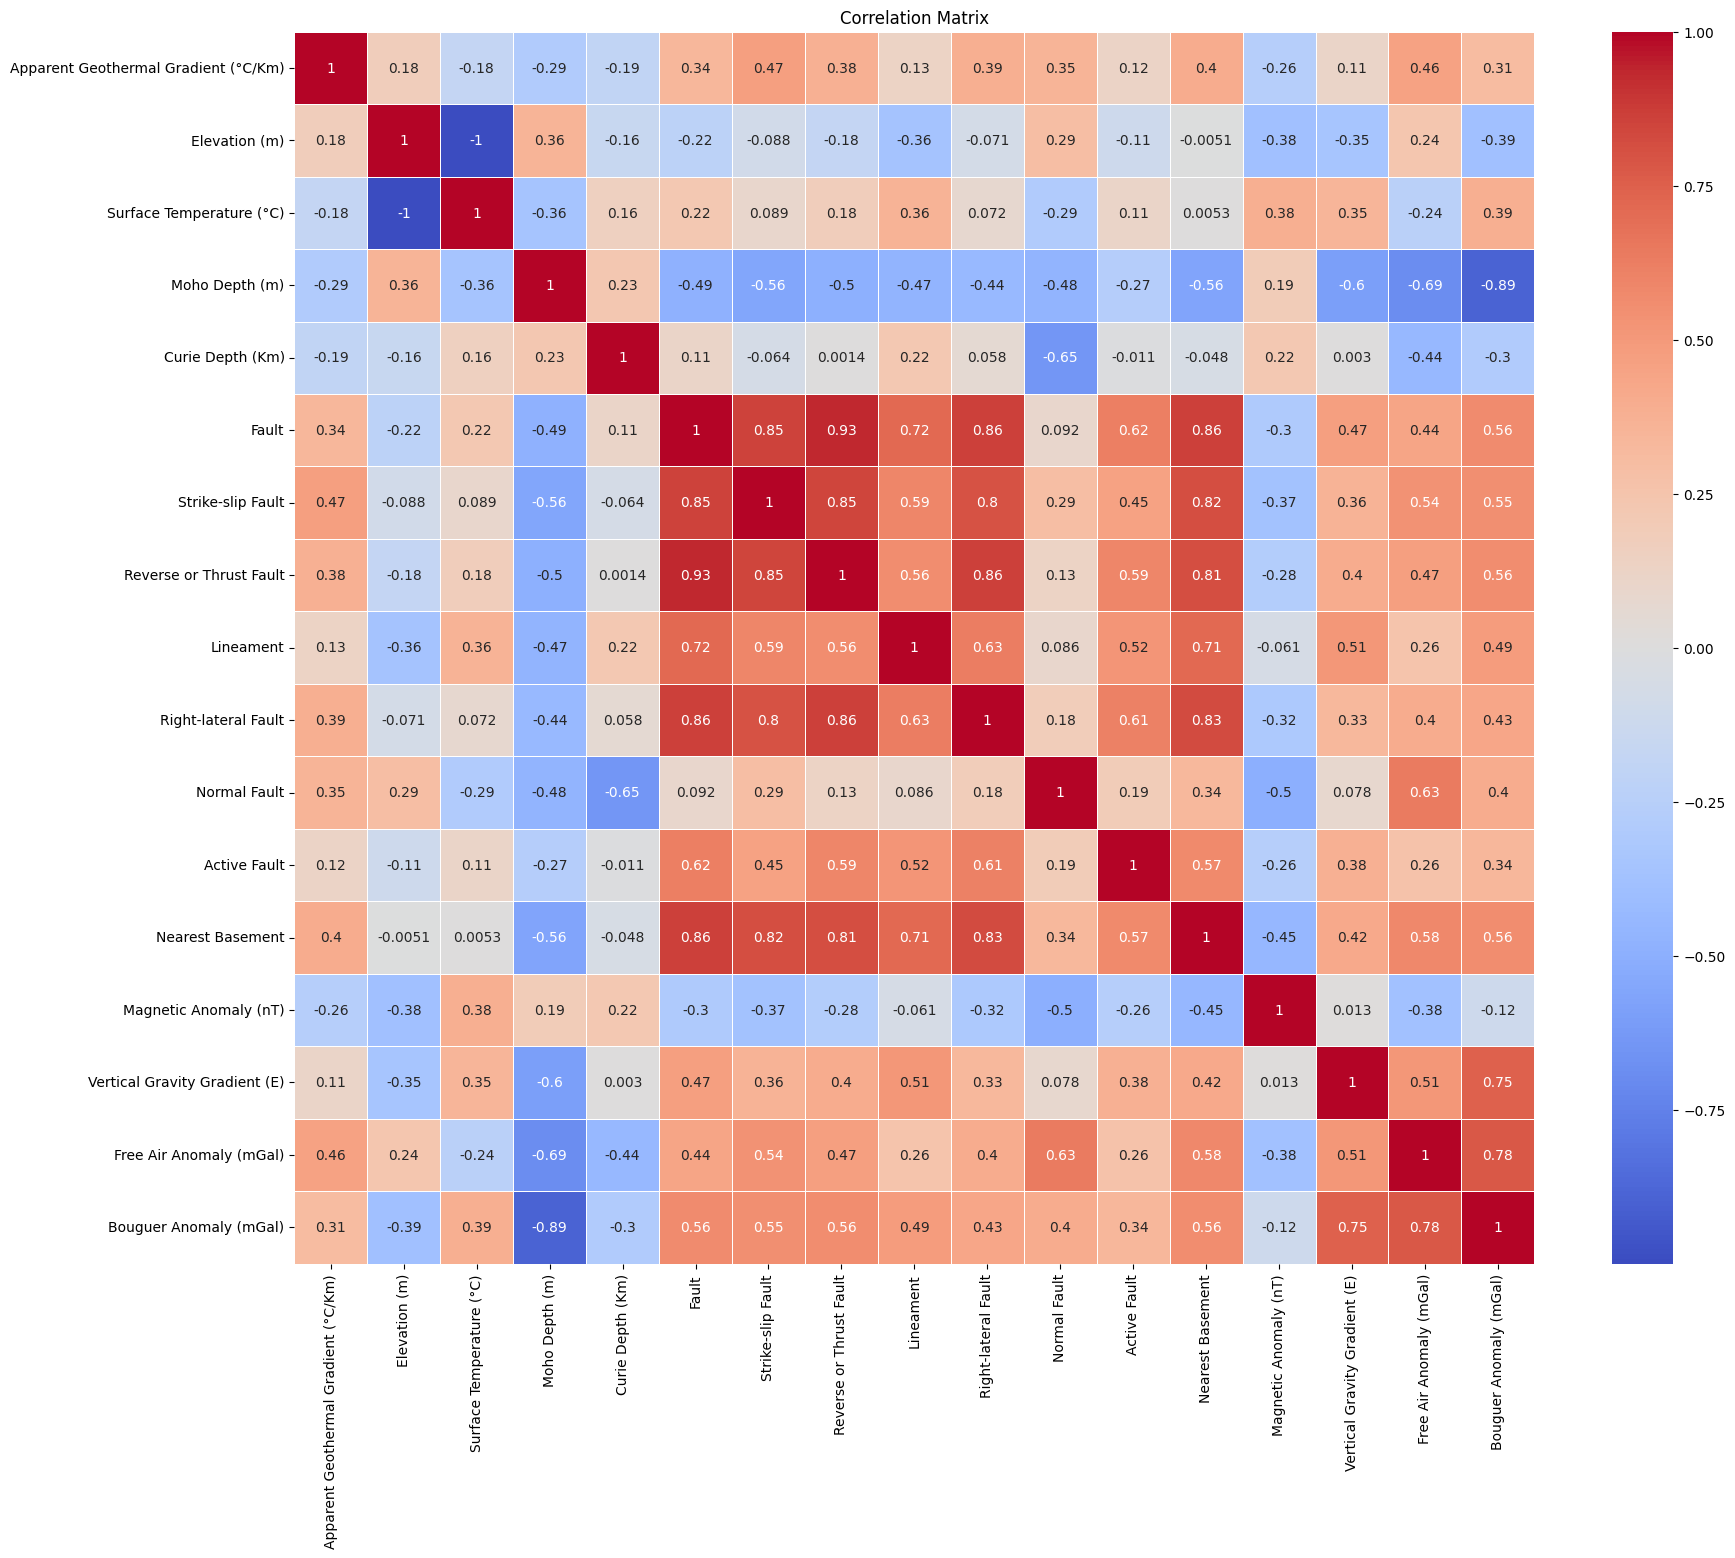

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the desired columns
selected_columns = ['Apparent Geothermal Gradient (°C/Km)', 
       'Elevation (m)', 'Surface Temperature (°C)',
       'Moho Depth (m)', 'Curie Depth (Km)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Nearest Basement', 
       'Magnetic Anomaly (nT)', 'Vertical Gravity Gradient (E)', 
       'Free Air Anomaly (mGal)','Bouguer Anomaly (mGal)']

# Create a DataFrame with the selected columns
selected_data = cleaned_data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Building Machine Learning Algorithm

## Data Splitting

In [81]:
cleaned_data.columns

Index(['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)', 'Moho Depth (m)',
       'Magnetic Anomaly (nT)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Curie Depth (Km)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)', 'Nearest Basement', 'Nearest Volcano',
       'Volcanic domain', 'Volcanic weight', 'High Gradient weight',
       'sample_weight'],
      dtype='object')

In [82]:
# Define feature matrix (X) and target variables (y)
X = cleaned_data[['Latitude', 'Longitude', 'Elevation (m)',
       'Curie Depth (Km)','Moho Depth (m)', 
       'Strike-slip Fault', 'Reverse or Thrust Fault', 
       'Right-lateral Fault', 'Nearest Basement',
       'Normal Fault', 'Active Fault','Magnetic Anomaly (nT)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)']]

y = cleaned_data['Apparent Geothermal Gradient (°C/Km)']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test, weights_train, _ = train_test_split(X, y, weights, test_size=0.2)

# Save X_test with lat and lon for plotting later
X_test_with_lat_lon = X_test[['Latitude', 'Longitude']].copy()

# Save X with lat and lon for plotting later
X_lat_lon = X[['Latitude', 'Longitude']].copy()

# Remove lat and lon from X to predict on the whole dataset
X = X.drop(['Latitude', 'Longitude'], axis=1)

#Remove lat and lon from X_train and X_test
X_train = X_train.drop(['Latitude', 'Longitude'], axis=1)
X_test = X_test.drop(['Latitude', 'Longitude'], axis=1)

## Hyperparameter Tuning

Manually iterating over hyperparameter combinations and recording the progress using the tqdm library. 

In [83]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import numpy as np
from tqdm import tqdm

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 0.15, 0.3],
    'min_child_weight': [1, 5, 10],
    'colsample_bytree': [0.3, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 2],
    'subsample': [0.5, 0.7, 1],
}

best_params = {}
best_mse = float('inf')

# Use tqdm to display a progress bar
total_combinations = len(list(ParameterGrid(param_grid)))
with tqdm(total=total_combinations) as pbar:
    for params in ParameterGrid(param_grid):
        # Initialize the XGBRegressor with the current set of parameters
        xgb_model = xgb.XGBRegressor(**params)
        # Fit the model using the training data, target, and sample weights
        xgb_model.fit(X_train, y_train, sample_weight=weights_train)
        # Predict on the test set
        y_pred = xgb_model.predict(X_test)
        # Calculate the mean squared error on the test set
        mse = mean_squared_error(y_test, y_pred)
        # If the calculated MSE is lower than the best MSE, update the best parameters and best MSE
        if mse < best_mse:
            best_params = params
            best_mse = mse
        # Update the progress bar
        pbar.update(1)

print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)

100%|██████████| 6561/6561 [39:55<00:00,  2.74it/s]  

Best Hyperparameters: {'colsample_bytree': 0.3, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.5}
Best Mean Squared Error: 13.696779452641826


In [84]:
best_params = {'colsample_bytree': 0.3, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.5}

## Train XGBoost and evaluate model

In [85]:
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train, sample_weight=weights_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [93]:
import joblib
joblib.dump(best_xgb_model, 'trained_model.pkl')

['trained_model.pkl']

In [94]:
import joblib
best_xgb_model = joblib.load('trained_model.pkl')

Evaluate the model's performance on the test data using appropriate regression metrics (e.g., MAE, RMSE, R-squared).

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on the training set
y_train_pred = best_xgb_model.predict(X_train)

# Metrics for the training set
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)

print("Training Set Metrics:")
print(f"MAE: {mae_train}")
print(f"RMSE: {rmse_train}")
print(f"R-squared: {r2_train}")

Training Set Metrics:
MAE: 1.5677184453995323
RMSE: 2.06061523401445
R-squared: 0.842566711865588


In [95]:
# Predictions on the test set
y_test_pred = best_xgb_model.predict(X_test)

# Metrics for the test set
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

print("\nTest Set Metrics:")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R-squared: {r2_test}")


Test Set Metrics:
MAE: 2.6065912782131004
RMSE: 3.7009160288558056
R-squared: 0.4988041802786993


# Visualization of results

In [88]:
y_pred = y_test_pred

## Residual Plot

Create a residual plot to check if the model's predictions have a pattern. Most residuals must be near to zero

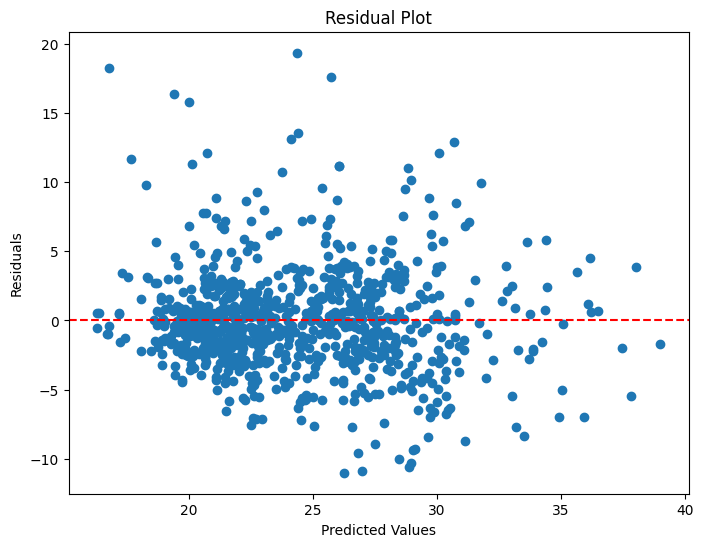

In [89]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.show()

## Actual vs. Predicted Plot

Visualize how model's predictions compare to the actual values.

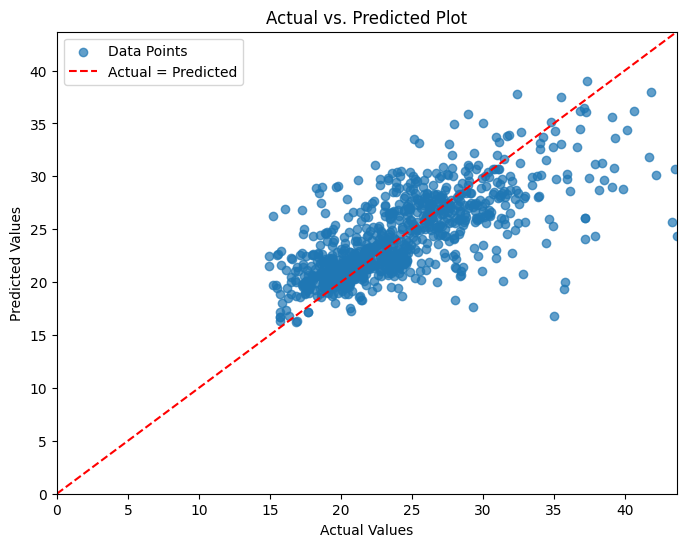

In [90]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Data Points', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot')

# Set x and y axis limits to start at 0,0
plot_max = max(max(y_test), max(y_pred))
plt.xlim(0, plot_max)
plt.ylim(0, plot_max)

# Plot the line where Actual = Predicted
plt.plot([0, plot_max], [0, plot_max], color='red', linestyle='--', label='Actual = Predicted')

plt.legend()
plt.show()

## Feature Importance Plot

Visualize the importance of each feature in the Random Forest model. This will help to understand which features have the most significant impact on predicting the geothermal gradient.

<Figure size 2000x3000 with 0 Axes>

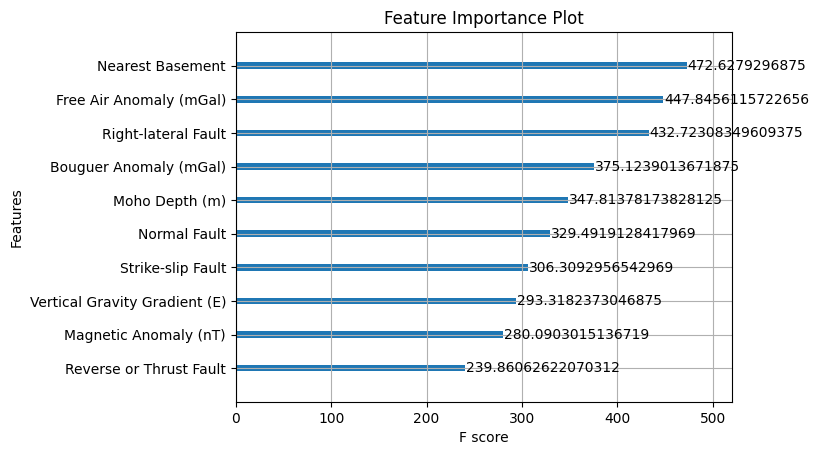

In [92]:
# Plot feature importance
plt.figure(figsize=(20, 30))
xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=10)
plt.title('Feature Importance Plot')
plt.show()

## RFE & Permutation Importance

In [96]:
from xgboost import plot_importance
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_regression

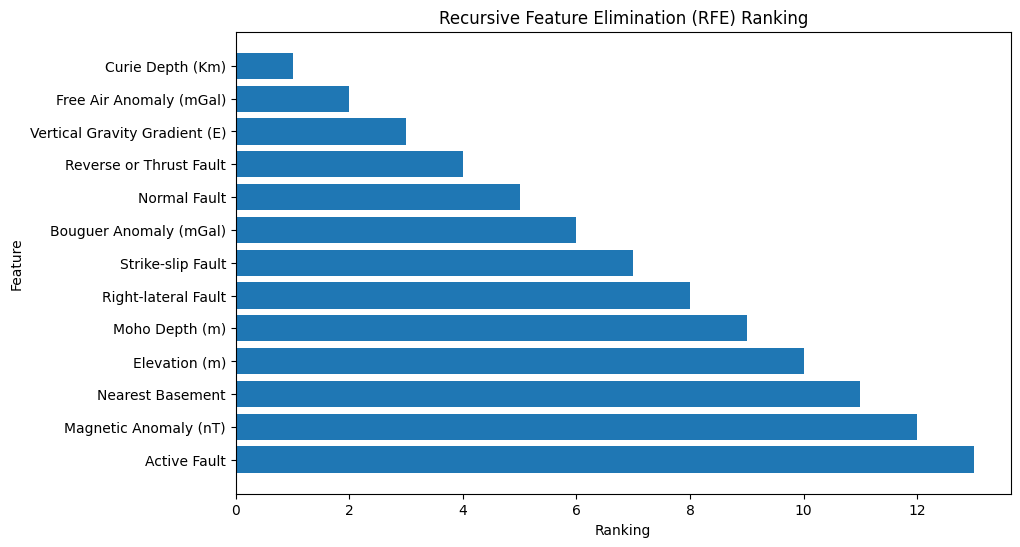

In [97]:
# Recursive Feature Elimination (RFE)
selector = RFE(best_xgb_model, n_features_to_select=1)
selector = selector.fit(X_train, y_train)
feature_ranking = selector.ranking_

# Get the names of features
feature_names = X_train.columns

# Sort the features based on their ranking
sorted_idx = feature_ranking.argsort()
sorted_ranking = feature_ranking[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot feature ranking
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_ranking)), sorted_ranking, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)  # Set feature names on y-axis
plt.title('Recursive Feature Elimination (RFE) Ranking')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

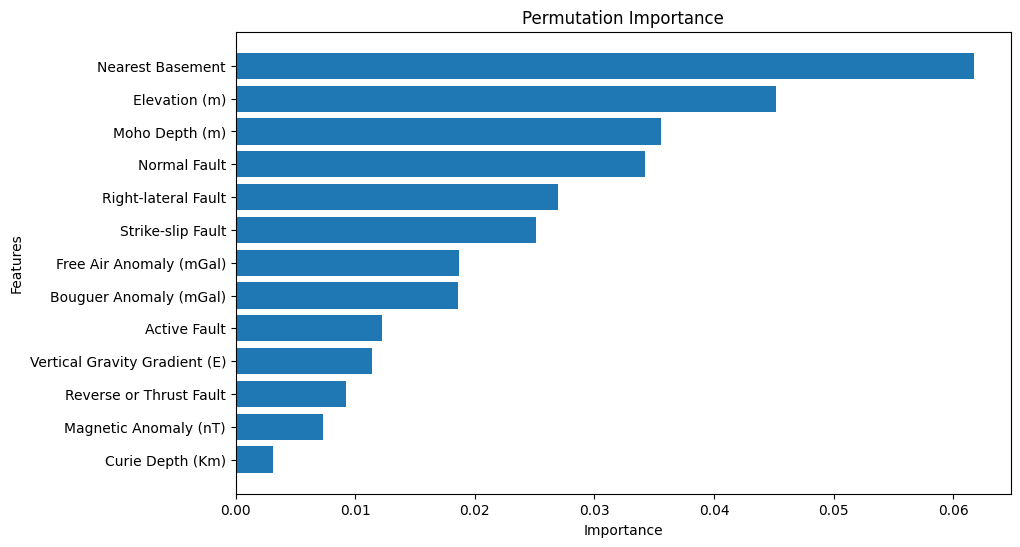

In [98]:
# Permutation Importance
perm_importance = permutation_importance(best_xgb_model, X_test, y_test, n_repeats=30, random_state=42)

# Plot permutation importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(X_test.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.title('Permutation Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Mutual Information

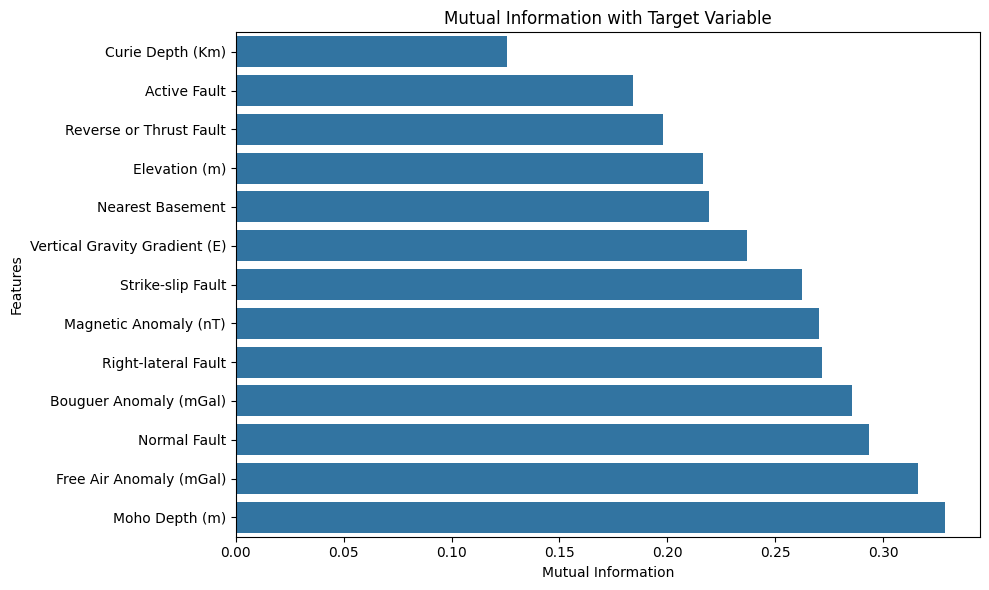

In [100]:
# Compute Mutual Information
mi = mutual_info_regression(X_train, y_train)

# Get the sorted indices (from lowest to highest mutual information)
sorted_indices = mi.argsort()

# Use the sorted indices to order the mutual information scores and feature names
sorted_mi = mi[sorted_indices]
sorted_feature_names = X_train.columns[sorted_indices]

# Plot mutual information
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_mi, y=sorted_feature_names)
plt.title('Mutual Information with Target Variable')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.tight_layout()  # Adjust layout to fit the figure neatly
plt.show()

## Regression results

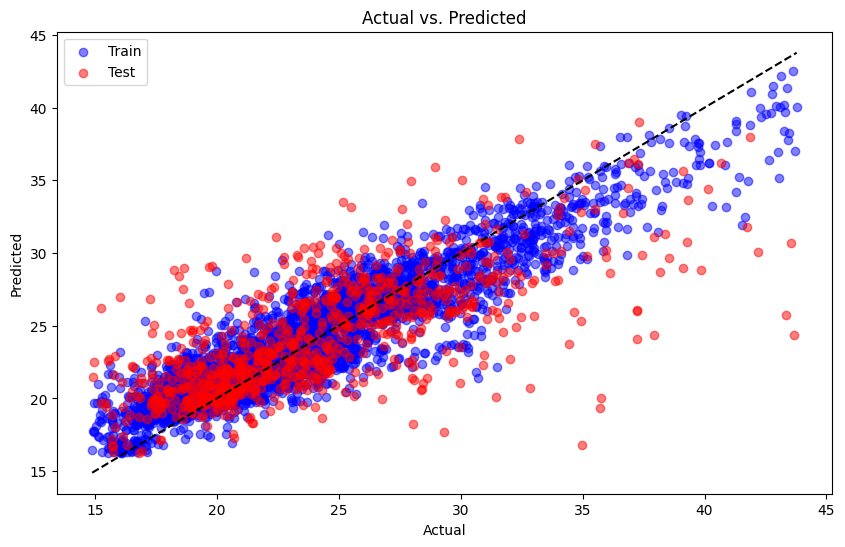

In [101]:
import matplotlib.pyplot as plt

# Use the model to make predictions on the training and test sets
y_train_pred = best_xgb_model.predict(X_train)
y_pred = best_xgb_model.predict(X_test)

# Create a scatter plot of the actual vs. predicted values for the training set
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Train', alpha=0.5)

# Create a scatter plot of the actual vs. predicted values for the test set
plt.scatter(y_test, y_pred, color='red', label='Test', alpha=0.5)

# Plot a line for perfect fit
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')

# Set the labels and title
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.legend()

# Show the plot
plt.show()

## Geospatial visualization

### Actual data

In [102]:
import geopandas as gpd

In [103]:
actual_data = pd.read_csv('normalized_data_minmax.csv')

In [104]:
actual_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Moho Depth (m),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,...,Curie Depth (Km),Vertical Gravity Gradient (E),Free Air Anomaly (mGal),Bouguer Anomaly (mGal),Nearest Basement,Nearest Volcano,Volcanic domain,Volcanic weight,High Gradient weight,sample_weight
0,4.216078,-74.888898,0.100557,0.899443,21.294394,0.720455,0.359897,0.053527,0.102362,0.022877,...,0.642857,0.341539,0.096100,0.241172,0.107926,0.034629,True,1,1,1
1,4.214720,-74.891220,0.101535,0.898465,23.783404,0.720641,0.359897,0.054497,0.102794,0.022201,...,0.642857,0.341539,0.096100,0.241172,0.107145,0.034457,True,1,1,1
2,0.606276,-76.564731,0.088329,0.911671,24.156323,0.412171,0.515283,0.121886,0.168226,0.112310,...,0.357143,0.467743,0.319461,0.615321,0.173626,0.081206,False,4,1,4
3,0.305911,-76.914853,0.029052,0.970948,25.601245,0.483869,0.521874,0.126023,0.144177,0.097701,...,0.357143,0.460502,0.316090,0.628522,0.176712,0.093585,False,4,1,4
4,0.287539,-76.911964,0.095470,0.904530,26.559722,0.477817,0.521874,0.130004,0.149747,0.101809,...,0.357143,0.460502,0.360872,0.644461,0.181525,0.095853,False,4,1,4


### Predicted data

In [105]:
# Make predictions using the entire dataset (X)
y_pred_full = best_xgb_model.predict(X)

# Update your existing DataFrame or create a new one to store the predictions
X_lat_lon['Predicted Geothermal Gradient (°C/Km)'] = y_pred_full

In [106]:
X_lat_lon.head()

,Latitude,Longitude,Predicted Geothermal Gradient (°C/Km)
0,4.216078,-74.888898,24.185080
1,4.214720,-74.891220,24.044371
2,0.606276,-76.564731,25.291161
3,0.305911,-76.914853,24.003675
4,0.287539,-76.911964,26.620619


In [107]:
X_lat_lon.to_csv('predicted_dataset.csv', index=False)

In [108]:
X_lat_lon = pd.read_csv('predicted_dataset.csv')

### Plot actual and predicted

/tmp/ipykernel_27271/1562596514.py:41: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


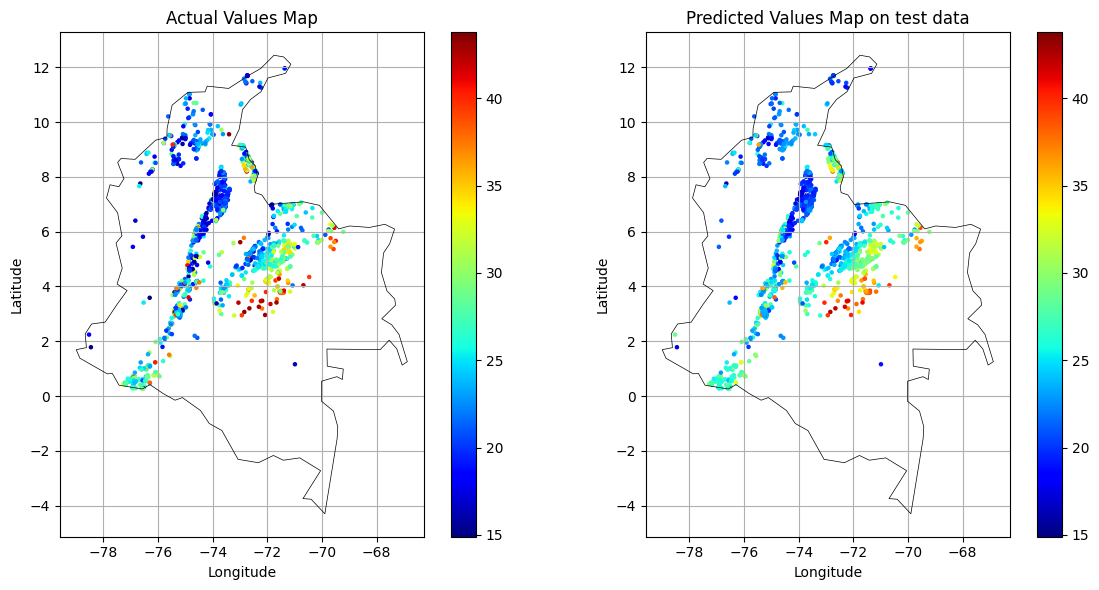

In [109]:
# Load GeoDataFrame for actual values
actual_gdf = gpd.GeoDataFrame(actual_data, geometry=gpd.points_from_xy(actual_data['Longitude'], actual_data['Latitude']))

# Load GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(X_lat_lon, geometry=gpd.points_from_xy(X_lat_lon['Longitude'], X_lat_lon['Latitude']))

# Determine the common color range
vmin = min(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].min(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].min())
vmax = max(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].max(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].max())

# Create subplots with two axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cmap = 'jet'

# Plot actual values on the first subplot
actual_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap=cmap, markersize=5, legend=True, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('Actual Values Map')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot predicted values on the second subplot
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap=cmap, markersize=5, legend=True, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('Predicted Values Map on test data')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon to both subplots
for ax in axes:
    ax.set_xticks(lon_grid)
    ax.set_yticks(lat_grid)
    ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest for both subplots
for ax in axes:
    world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the combined plot with both subplots
plt.tight_layout()
plt.show()


### Difference between actual and predicted

/tmp/ipykernel_27271/3571925784.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


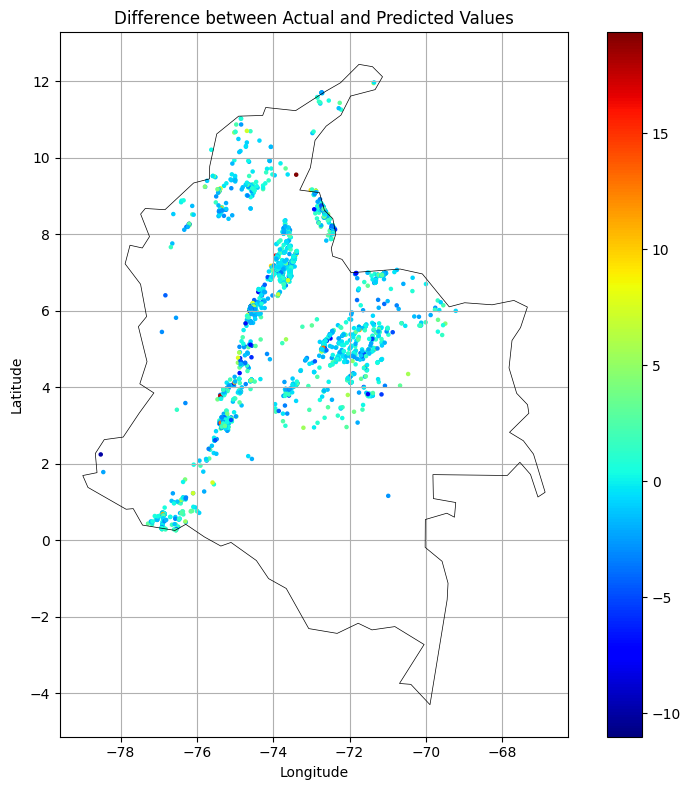

In [110]:
# Calculate the difference between actual and predicted values
actual_gdf['Apparent Geothermal Gradient (°C/Km)'] = actual_gdf['Apparent Geothermal Gradient (°C/Km)'] - predicted_gdf['Predicted Geothermal Gradient (°C/Km)']

# Create a plot for the difference values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
difference_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap=cmap, markersize=5, legend=True, ax=ax)
ax.set_title('Difference between Actual and Predicted Values')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon
ax.set_xticks(lon_grid)
ax.set_yticks(lat_grid)
ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the plot
plt.tight_layout()
plt.show()


## Feature influence

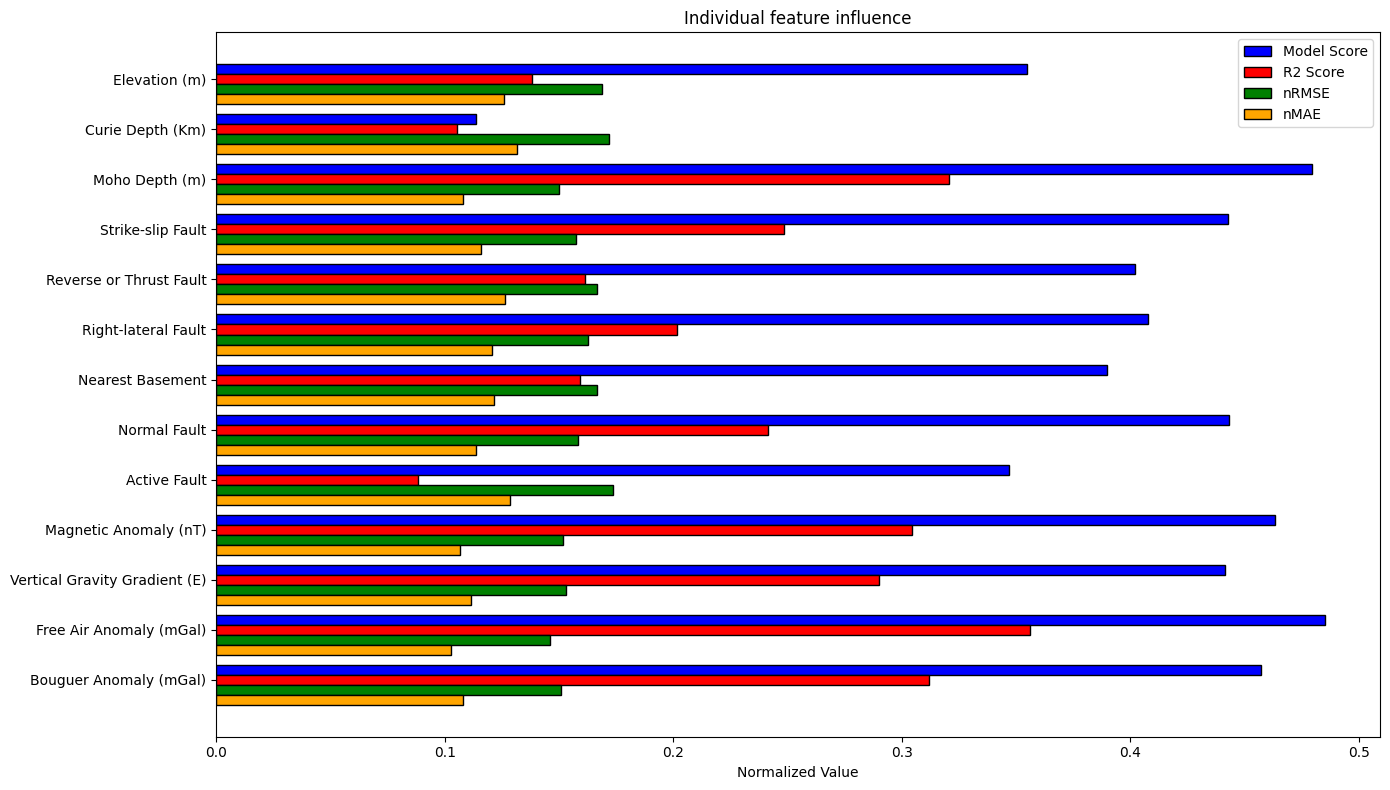

In [113]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Initialize lists to store results
features = []
training_scores = []
test_scores = []
nRMSEs = []
nMAEs = []

# Iterate over each feature in the dataset
for feature in X_train.columns:
    # Train the model using only this feature
    best_xgb_model.fit(X_train[[feature]], y_train)
    
    # Calculate the training score (model score)
    training_score = best_xgb_model.score(X_train[[feature]], y_train)
    training_scores.append(training_score)
    
    # Use the model to make predictions on the test set
    predictions = best_xgb_model.predict(X_test[[feature]])
    
    # Calculate the test score (R2 score)
    test_score = r2_score(y_test, predictions)
    test_scores.append(test_score)
    
    # Calculate the normalized Root Mean Square Error (nRMSE)
    nRMSE = np.sqrt(mean_squared_error(y_test, predictions)) / (y_test.max() - y_test.min())
    nRMSEs.append(nRMSE)
    
    # Calculate the normalized Mean Absolute Error (nMAE)
    nMAE = mean_absolute_error(y_test, predictions) / (y_test.max() - y_test.min())
    nMAEs.append(nMAE)
    
    # Store the feature name
    features.append(feature)

# Plot the results
plt.figure(figsize=(14, 8))
y_pos = np.arange(len(features))
bar_width = 0.2

# Plot each metric
plt.barh(y_pos, training_scores, bar_width, label='Model Score', color='b', edgecolor='black')
plt.barh(y_pos + bar_width, test_scores, bar_width, label='R2 Score', color='r', edgecolor='black')
plt.barh(y_pos + 2*bar_width, nRMSEs, bar_width, label='nRMSE', color='g', edgecolor='black')
plt.barh(y_pos + 3*bar_width, nMAEs, bar_width, label='nMAE', color='orange', edgecolor='black')

# Label axes and title
plt.xlabel('Normalized Value')
plt.yticks(y_pos + bar_width, features)
plt.title('Individual feature influence')
plt.legend()

# Display the plot
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.tight_layout()
plt.show()

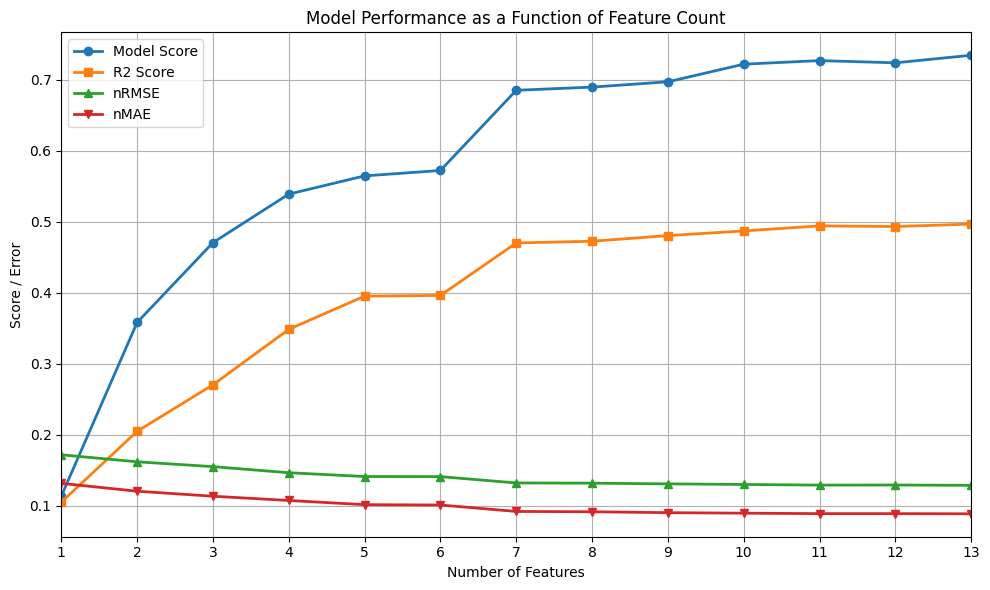

In [111]:
# Get feature importance by gain
importance = best_xgb_model.get_booster().get_score(importance_type='gain')

# Sort the features by their importance score
sorted_features = sorted(importance, key=importance.get, reverse=False)

# Now proceed with your existing code
num_features = []
training_scores = []
test_scores = []
nRMSEs = []
nMAEs = []

# Iterate over each feature in the sorted feature list
for i in range(len(sorted_features)):
    # Get the current feature and all previous features
    current_features = sorted_features[:i+1]
    
    # Train the model using these features
    best_xgb_model.fit(X_train[current_features], y_train)
    
    # Calculate the training score (model score)
    training_score = best_xgb_model.score(X_train[current_features], y_train)
    training_scores.append(training_score)
    
    # Use the model to make predictions on the test set
    predictions = best_xgb_model.predict(X_test[current_features])
    
    # Calculate the test score (R2 score)
    test_score = r2_score(y_test, predictions)
    test_scores.append(test_score)
    
    # Calculate the normalized Root Mean Square Error (nRMSE)
    nRMSE = np.sqrt(mean_squared_error(y_test, predictions)) / (y_test.max() - y_test.min())
    nRMSEs.append(nRMSE)
    
    # Calculate the normalized Mean Absolute Error (nMAE)
    nMAE = mean_absolute_error(y_test, predictions) / (y_test.max() - y_test.min())
    nMAEs.append(nMAE)
    
    # Store the number of features
    num_features.append(i+1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_features, training_scores, label='Model Score', linewidth=2, marker='o')
plt.plot(num_features, test_scores, label='R2 Score', linewidth=2, marker='s')
plt.plot(num_features, nRMSEs, label='nRMSE', linewidth=2, marker='^')
plt.plot(num_features, nMAEs, label='nMAE', linewidth=2, marker='v')

# Enhance plot aesthetics
plt.title('Model Performance as a Function of Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('Score / Error')
plt.xticks(range(1, len(sorted_features) + 1))  # Ensure x-axis ticks match feature counts
plt.grid(True)
plt.legend()

# Annotations and Axis Adjustments
max_feature_count = len(sorted_features)
plt.xlim(1, max_feature_count)
plt.xticks(np.arange(1, max_feature_count + 1, step=1))  # Adjust step based on feature count

plt.tight_layout()
plt.show()

## Load the model again

This is done as the feature influence modifies the model

In [114]:
best_xgb_model = joblib.load('trained_model.pkl')

# Predicting new values (Colombia)

We'll use a Colombia Cities Database to extract latitude and longitude data for the whole country (over 9000 geographic points)

In [ ]:
points = pd.read_csv('full_prediction_points.csv')
points.head()

## Add distance to nearest basement (surface)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm

gdf_points = gpd.GeoDataFrame(
    points,
    geometry=gpd.points_from_xy(points.Longitude, points.Latitude),
    crs="EPSG:4326"  # WGS84
)

# Load the 'basement' shapefile
basement = gpd.read_file('data/Geology/Rock_types.shx')

# Filter 'basement' to only include rows where 'classified' equals 1
basement_classified_1 = basement[basement['classified'] == 1]

# Reproject both GeoDataFrames to MAGNA-SIRGAS (EPSG:3116)
gdf_cleaned_data = gdf_cleaned_data.to_crs("EPSG:3116")
basement_classified_1 = basement_classified_1.to_crs("EPSG:3116")

# Initialize a column for the distances
points['Nearest Basement'] = np.nan

# Calculate the distance from each point in 'gdf_cleaned_data' to the nearest '1' in 'basement_classified_1'
for index, row in tqdm(gdf_cleaned_data.iterrows(), total=gdf_cleaned_data.shape[0], desc="Calculating distances"):
    # Calculate the distance to the nearest point in 'basement_classified_1' and update the 'distance_to_1' column
    points.at[index, 'Nearest Basement'] = basement_classified_1.distance(row.geometry).min()

In [ ]:
points.head()

## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Elevation (m)', 'Moho Depth (m)', 
       'Curie Depth (Km)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault', 'Magnetic Anomaly (nT)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)', 'Nearest Basement']

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
points[columns_to_normalize] = scaler.fit_transform(points[columns_to_normalize])

# Save the normalized data to a new CSV file
points.to_csv('normalized_full_prediction.csv', index=False)

In [115]:
points = pd.read_csv('normalized_full_prediction.csv')
points.head()

,Longitude,Latitude,Elevation (m),Moho Depth (m),Magnetic Anomaly (nT),Curie Depth (Km),Free Air Anomaly (mGal),Vertical Gravity Gradient (E),Bouguer Anomaly (mGal),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault,Nearest Basement
0,-74.794856,0.111833,0.042328,0.285085,0.604210,0.642857,0.139375,0.251871,0.397807,0.266546,0.308912,0.196042,0.075754,0.214496,0.428156,0.264893,0.106408
1,-68.287650,4.736540,0.021164,0.444411,0.645887,0.571429,0.124705,0.264107,0.383486,0.226731,0.133889,0.505402,0.383612,0.131062,0.329133,0.266846,0.107926
2,-71.942279,2.436080,0.037037,0.359088,0.775058,0.857143,0.168955,0.261018,0.442627,0.120519,0.248059,0.250351,0.180583,0.257368,0.286651,0.303053,0.107145
3,-72.123881,-0.423472,0.037037,0.290403,0.410328,0.785714,0.174712,0.263839,0.450150,0.490443,0.457458,0.439029,0.104542,0.469740,0.600280,0.511041,0.173626
4,-74.030652,9.612854,0.015873,0.531744,0.547240,0.500000,0.095775,0.252227,0.335302,0.060130,0.028778,0.047006,0.328612,0.076047,0.296188,0.048054,0.176712


## Prediction

In [116]:
selected_features = ['Elevation (m)',
       'Curie Depth (Km)','Moho Depth (m)', 
       'Strike-slip Fault', 'Reverse or Thrust Fault', 
       'Right-lateral Fault', 'Nearest Basement',
       'Normal Fault', 'Active Fault','Magnetic Anomaly (nT)',
       'Vertical Gravity Gradient (E)', 'Free Air Anomaly (mGal)',
       'Bouguer Anomaly (mGal)']

# Create a new DataFrame with the selected columns
selected_data = points[selected_features]

X_new = selected_data.values  # Convert the DataFrame to a 2D numpy array

# Use the XGBoost model to make predictions
y_pred_new = best_xgb_model.predict(X_new)

# Add the predicted values to the points DataFrame
points['Predicted Geothermal Gradient (°C/Km)'] = y_pred_new


In [117]:
predicted_new = points

In [119]:
points.to_csv('predicted_new.csv', index=False)

In [ ]:
predicted_new = pd.read_csv('predicted_new.csv')
predicted_new.head()

In [ ]:
sns.histplot(predicted_new['Predicted Geothermal Gradient (°C/Km)'], kde=False)

### Plot map

/tmp/ipykernel_27271/884958366.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


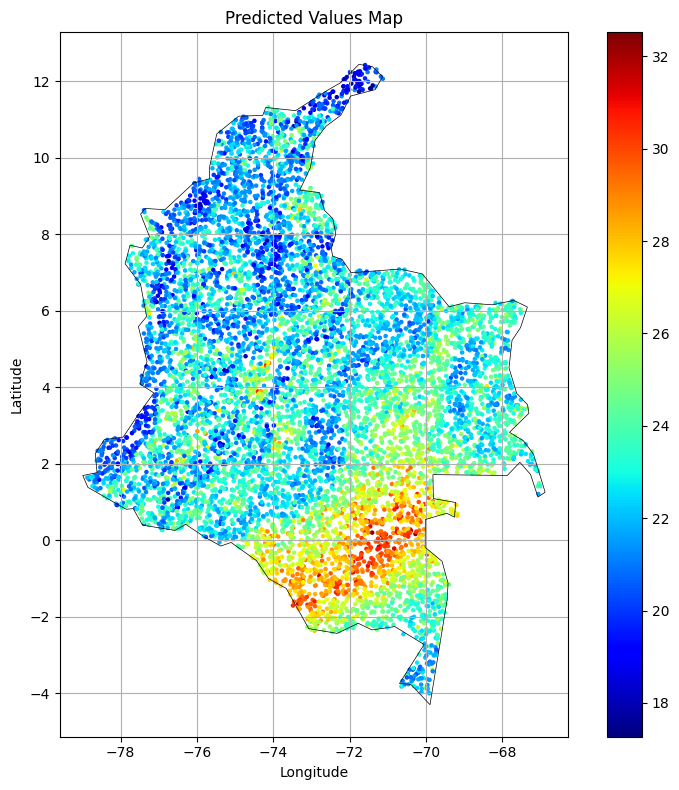

In [121]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(predicted_new, geometry=gpd.points_from_xy(predicted_new['Longitude'], predicted_new['Latitude']))

# Determine the color range
vmin = predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].min()
vmax = predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].max()

# Create a subplot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the predicted values
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap=cmap, markersize=5, legend=True, ax=ax)
ax.set_title('Predicted Values Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Calculate grid positions based on your data's latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for latitude and longitude
ax.set_xticks(lon_grid)
ax.set_yticks(lat_grid)
ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the plot
plt.tight_layout()
plt.show()